symbols:  [ 1  1 -1 -1  1 -1 -1 -1 -1  1  1  1  1 -1  1  1  1 -1 -1 -1  1 -1  1 -1
 -1 -1  1  1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1  1  1 -1
 -1 -1]
channel output:  [ 0.9  1.3 -0.4 -1.3  0.4 -0.4 -1.3 -1.3 -1.3  0.4  1.3  1.3  1.3 -0.4
  0.4  1.3  1.3 -0.4 -1.3 -1.3  0.4 -0.4  0.4 -0.4 -1.3 -1.3  0.4  1.3
 -0.4 -1.3 -1.3  0.4  1.3 -0.4  0.4 -0.4 -1.3  0.4  1.3  1.3 -0.4  0.4
  1.3  1.3 -0.4  0.4  1.3 -0.4 -1.3 -1.3]
ZF equalizer output:  [ 1.  1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1.
 -1. -1.  1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.
 -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1. -1. -1. -1.]
decided symbols:  [ 1  1 -1 -1  1 -1 -1 -1 -1  1  1  1  1 -1  1  1  1 -1 -1 -1  1 -1  1 -1
 -1 -1  1  1 -1 -1 -1  1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1  1  1 -1
 -1 -1]
SER = 0.00e+00
SER ZF = 0.00e+00


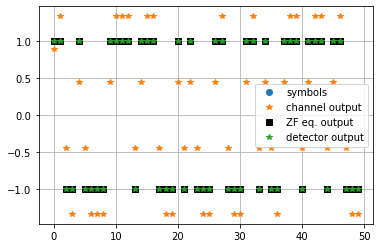

In [240]:
import numpy as np
from scipy import signal
from numpy.random import randint
import matplotlib.pyplot as plt

N = 50  # length of transmitting sequence
s = (-1) ** (np.floor(2 * np.random.rand(N)))  # creating PAM symbols

Es = np.mean(s**2)
s = s/np.sqrt(Es)

# Sending Through the Channel
h = np.array([0.815, 0.407])  # channel with finite impulse response
h = h / np.sqrt(np.sum(h**2)) # normalize impulse response

x = np.convolve(h, s,'same')

# Adding Noise
SNRdB = 100
σ = np.sqrt(1 / (10 ** (SNRdB / 10)))
n = np.random.normal(0, σ, len(x))
y = x + n

# Linear Zero Forcing at the Receiver
h_tf = signal.TransferFunction(h, 1)
h_ZF_num, h_ZF_den = h_tf.den, h_tf.num
xh = signal.lfilter(h_ZF_num, h_ZF_den, y)
#xh = np.roll(xh,1)

# detector (hard decisions)
xd = np.zeros(xh.shape, dtype=int)
xd[xh > 0] = 1
xd[xh < 0] = -1

plt.plot(s,'o', label='symbols')
plt.plot(x,'*', label='channel output')
plt.plot(xh,'ks', label='ZF eq. output')
plt.plot(xd,'*', label='detector output')
plt.legend()
plt.grid()

print('symbols: ', s.astype(int))
print('channel output: ',np.round(x,1))
print('ZF equalizer output: ',np.round(xh,1))
print('decided symbols: ',xd.astype(int))
print(f'SER = {np.mean((s[discard:-discard]>0)^(y[discard:-discard]>0)):.2e}')
print(f'SER ZF = {np.mean((s[1:]>0)^(xd[1:]>0)):.2e}')

In [ ]:
import numpy as np
from scipy.linalg import toeplitz

def mmseEq(y, h, noiseVar, M, L):
    """
    Perform Minimum Mean Square Error (MMSE) equalization on a received signal.

    Parameters:
    ----------
    y : ndarray
        1-D numpy array representing the received signal.
    h : ndarray
        1-D numpy array representing the impulse response of the channel.
    noiseVar : float
        Scalar value representing the noise variance.
    M : int
        Filter length.
    L : int
        Length parameter.

    Returns:
    -------
    xh : ndarray
        1-D numpy array representing the MMSE equalized signal.
    """

    h[-1::-1] = h  # Reverse the order of elements in the h array

    # MMSE equalization
    d = np.ceil(((M + L) - 1) / 2).astype(np.int64)  # Calculate d as the ceiling of ((M+L)-1)/2 and convert it to an integer
    H = np.toeplitz(np.concatenate(([h[0]], np.zeros(M - 1))), np.concatenate((h, np.zeros(M - 1))))  # Create Toeplitz matrix H
    u = np.concatenate((np.zeros(d), [1], np.zeros(d)))  # Create u vector with zero padding on both sides and a value of 1 in the middle
    s = H @ u  # Multiply H and u to obtain s

    ss = np.outer(s, s)  # Compute the outer product of s with itself to obtain ss

    indi = np.arange(-d, d + 1)  # Generate array indi representing the required indices for calculations
    indo = np.arange(-d + L, d + 1)  # Generate array indo representing the required indices for calculations

    xh = y.copy()  # Create a copy of the received signal y as xh

    # Calculate MMSE estimated transmitted sequence
    for indk in range(d, len(y) - d):
        ck = np.linalg.pinv(noiseVar * np.eye(M) + H @ H.T) @ s  # Calculate MMSE filter using the pseudo inverse
        xh[indk] = ck @ y[indo + indk]  # Compute the equalized symbol by multiplying ck with the relevant portion of the received signal

    return xh

symbols:  [ 1  1  1 ... -1  1  1]
channel output:  [ 0.2  1.2  1.4 ...  0.5 -0.5  0.9]
MMSE equalizer output:  [ 0.3  1.3  1.4 ...  0.4 -0.8  0.8]
decided symbols:  [ 1  1  1 ...  1 -1  1]
SER = 4.81e-01
SER MMSE = 6.71e-03


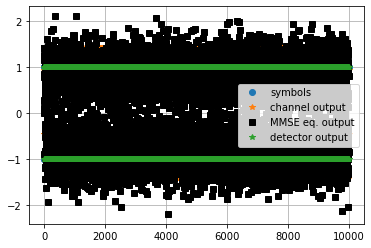

In [229]:
import numpy as np
from scipy import signal
from numpy.random import randint
from scipy.linalg import toeplitz

N = 10000  # length of transmitting sequence
s = (-1) ** (np.floor(2 * np.random.rand(N)))  # creating PAM symbols

Es = np.mean(s**2)
s = s/np.sqrt(Es)

# Sending Through the Channel
h = np.array([0.207, 0.815, 0.207])  # channel with finite impulse response
h = h / np.sqrt(np.sum(h**2))  # normalize impulse response

x = signal.lfilter(h, 1, s)

# Adding Noise
SNRdB = 10
σ = np.sqrt(1 / (10 ** (SNRdB / 10)))
n = np.random.normal(0, σ, len(x))
y = x + n

# MMSE Equalization at the Receiver
M = 7
L = 2
xh = mmseEq(y, h, σ**2, M, L)
#xh = np.roll(xh,1)

# Detector (Hard Decisions)
xd = np.zeros(xh.shape, dtype=int)
xd[xh > 0] = 1
xd[xh < 0] = -1

plt.plot(s,'o', label='symbols')
plt.plot(x,'*', label='channel output')
plt.plot(xh,'ks', label='MMSE eq. output')
plt.plot(xd,'*', label='detector output')
plt.legend()
plt.grid()

discard = 10
print('symbols: ', s.astype(int))
print('channel output: ',np.round(x,1))
print('MMSE equalizer output: ',np.round(xh,1))
print('decided symbols: ',xd.astype(int))
print(f'SER = {np.mean((s[discard:-discard]>0)^(y[discard:-discard]>0)):.2e}')
print(f'SER MMSE = {np.mean((s[discard:-discard]>0)^(xd[discard:-discard]>0)):.2e}')